<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aims-and-objectives" data-toc-modified-id="Aims-and-objectives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aims and objectives</a></span></li><li><span><a href="#overarching-equation-bin" data-toc-modified-id="overarching-equation-bin-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>overarching equation bin</a></span></li><li><span><a href="#nutrition-[N],-phytoplankton-[P],-zooplankton-[Z],-detritus-[D]" data-toc-modified-id="nutrition-[N],-phytoplankton-[P],-zooplankton-[Z],-detritus-[D]-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>nutrition [N], phytoplankton [P], zooplankton [Z], detritus [D]</a></span></li><li><span><a href="#carbon-sequestration-revenue-(photosynthesis)-rate" data-toc-modified-id="carbon-sequestration-revenue-(photosynthesis)-rate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>carbon sequestration revenue (photosynthesis) rate</a></span></li><li><span><a href="#model-with-detritivore-population" data-toc-modified-id="model-with-detritivore-population-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>model with detritivore population</a></span></li><li><span><a href="#electricigen-detritivore-population-electricity-relationship" data-toc-modified-id="electricigen-detritivore-population-electricity-relationship-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>electricigen detritivore population-electricity relationship</a></span></li></ul></div>

In [1]:
using RCall, PyCall, Plots, ProgressMeter, DataFrames
mt = pyimport("math")
sc = pyimport("scipy")
cst = pyimport("scipy.constants")
itg = pyimport("scipy.integrate")
R"cbp<-c('#000000', '#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#e79f00', '#9ad0f3', '#F0E442', '#999999', '#cccccc', '#6633ff', '#00FFCC', '#0066cc')"
println()

# Aims and objectives
1. model replication on EMPOWER model ([Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf))
2. combine and list out equations useful for the model of eco-bioelectric cell
3. establish relationship between electricigen microbe population and power output

# overarching equation bin
Grazing
\begin{equation}
    G_X = ZI_{Zmx}\Big[ \dfrac{(X/k_X)^2}{1+(P/k_P)^2+(D/k_D)^2} \Big]\text{, which X = P or D} 
\end{equation}

In [2]:
function grazing(pops, kSer, X, igt) ## tested
    ## igt = maximum ingestion rate of zooplankton
    
    P = pops[:2] # phytoplankton population size
    Z = pops[:3] # zooplankton population size
    D = pops[:4] # detritivore population size
    
    kP = kSer[:2] # phytoplankton half-saturation constant
    kD = kSer[:3] # detritivore half-saturation constant
    
    if X==1
        X = kP
        kX = kP
    else
        X = kD
        kX = kD
    end
    
    gz = Z*igt*(X/kX)^2/(1+(P/kP)^2+(D/kD)^2)
    return(gz)
end

grazing (generic function with 1 method)

Light intensity
\begin{align}
    i_{t,z} &= i(t)e^{-k_{PAR}z}\\
    k_{PAR} &= b_{0,i} + b_{1,i}C^{0.5} + b_{2,i}C + \cdots + b_{5,i}C^{2.5}
\end{align}

In [3]:
function intensity(iT, C, z) ## tested
    ## C = chlorophyll conc
    ## bSer = coefficient series (6 elements) from paper for differential equation
    bSer=sc.array([0.13096, 0.030969, 0.042644, -.013738, 0.0024617, -.00018059]) # top 5m polynomial coefficients
    kPAR = bSer[:1] + bSer[:2]*C^.5 + bSer[:3]*C + bSer[:4]*C^1.5 + bSer[:5]*C^2 + bSer[:6]*C^2.5
    
    ## iT = incident irradiation at water surface
    ## kPAR = sum of attenuation due to water and phytoplankton
    iTz = iT*mt.exp(-kPAR*z)
    return(iTz)
end

intensity (generic function with 1 method)

phytoplankton growth rate
\begin{equation}
    \mu_P = \mu_P^{max}(0)\cdot1.066^T\cdot\dfrac{N}{k_N+N}\cdot\dfrac{I(t)}{k_{I,t}+I(t)}
\end{equation}

In [4]:
function gRateP(pops, kSer, mu0, T, IntMax, iT, C, z) ## tested
    ## mu0 = max growth rate when temperature = 0 deg Celcius
    ## T = temperature (deg Celcius)
    ## IntMx = maximum light intensity
    N = pops[:1] # nutrient population size
    kN = kSer[:1] # half-saturation constant: N-uptake
    
    muP = mu0*1.066^T*N/(kN+N)*intensity(iT, C, z)/(.5*IntMax+intensity(iT, C, z))
    return(muP)
end

gRateP (generic function with 1 method)

# nutrition [N], phytoplankton [P], zooplankton [Z], detritus [D]
\begin{equation}
\left\{\begin{array}{rl}
    N'(t) &= -\mu_PP + \beta_Z(1-k_{NZ})(G_P+G_D) + m_DD + (a_NZ + b_N - N)\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}\\
    P'(t) &= \mu_PP - G_P - m_PP - m_{P2}P^2 - P\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}\\
    Z'(t) &= \beta_Zk_N(G_P+G_D) - m_ZZ - m_{Z2}Z^2-Z\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}\\
    D'(t) &= m_PP + m_{P2}P^2 + m_ZZ + (1-\beta_Z)(G_P+G_D) - G_D - (m_D + \dfrac{v_D}{H(t)})D -D\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}
    \end{array}\right.
\end{equation}

In [5]:
function empower(pops, t, kSer, mSer, zSer, arb, depth, Temp, GR0deg, IntMax, irradiance, cplConc)
    ig = zSer[:1] # ingestion rate
    bZ = zSer[:2] # absorption rate
    kNZ = zSer[:3] # net production efficiency
    
    Ht = depth[:1] # considered water column height
    Hdt = depth[:2] # rate of change of thermocline (=0 in ebc)
    omgMix = depth[:3] # cross-thermocline mixing (=0 in ebc)
    
    muP = gRateP(pops, kSer, GR0deg, Temp, IntMax, irradiance, cplConc, Ht)
    GP = grazing(pops, kSer, 1, ig)
    GD = grazing(pops, kSer, 2, ig)
    Gpd = GP+GD
    oCf = omgMix*Hdt/Ht
    
    N = pops[:1] # nutrient population size
    P = pops[:2] # phytoplankton population size
    Z = pops[:3] # zooplankton population size
    D = pops[:4] # detritivore population size
    
    kN = kSer[:1] # half-saturation nutrient constant: N-uptake
    
    mP1 = mSer[:1] # phytoplankton mortality (lin)
    mP2 = mSer[:2] # phytoplankton mortality (qua)
    mZ1 = mSer[:3] # zooplankton mortality (lin)
    mZ2 = mSer[:4] # zooplankton mortality (qua)
    mD0 = mSer[:5] # detritus mortality (lin)
    vD = mSer[:6] # detritus sinking rate (=0 in ebc)
        
    aN = arb[:1] # subthermocline data slope
    bN = arb[:2] # subthermocline data intercept
    
    dN = -muP + bZ*(1-kNZ)*Gpd + mD0*D + (aN*Z + bN - N)*oCf
    dP = muP - GP - mP1*P - mP2*P^2 - P*oCf
    dZ = bZ*kN*Gpd - mZ1*Z - mZ2*Z^2 - Z*oCf
    dD = mP1*P + mP2*P^2 + mZ1*Z + (1-bZ)*Gpd - GD - D*(mD0+vD/Ht) - D*oCf
    
    return(sc.array([dN,dP,dZ,dD]))
end

empower (generic function with 1 method)

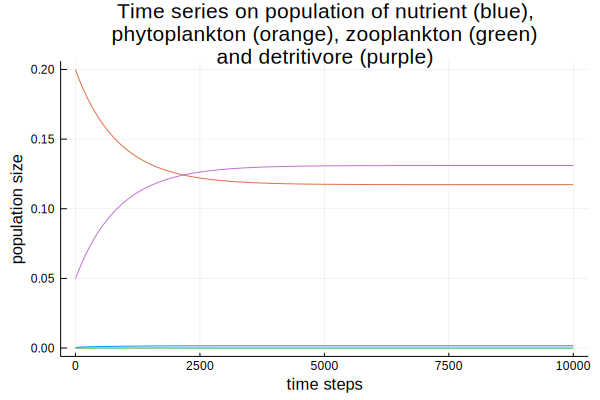

In [45]:
t = sc.linspace(0, 10, 10000) # time series (days)

## parameters
pops = sc.array([0,.2,0,.05]) # population size/density: NPZD
kSer = sc.array([.5,.5,.5,.5]) # half-saturation constant: NPZD
mSer = sc.array([.5,.5,.5,.5,.5,0]) # mortality: P1 P2 Z1 Z2 D sink_D
zSer = sc.array([.5,.5,.9]) # zooplankton details: ingestion rate, absorption rate, net production efficiency
arb = sc.array([.0174,3.91]) # subthermocline linear data plot
depth = sc.array([1,0,0]) # water depth details: water col height, rate of thermocline shift, cross-thermocline mixing (detritivore dominant once without layer mixing in water column)
Temp = 30 # water surface temperature
GR0deg = 3 # phytoplankton growth rate at 0 deg Celcius
IntMax = 9 # max light intensity
irradiance = 200 # irradiance at water surface
cplConc = .5 # chlorophyll concentration

pops, infodict = itg.odeint(empower, pops, t, full_output=true, args=(kSer, mSer, zSer, arb, depth, Temp, GR0deg, IntMax, irradiance, cplConc))
plot(pops, xlabel="time steps", ylabel="population size", title="Time series on population of nutrient (blue),\nphytoplankton (orange), zooplankton (green)\nand detritus (purple)", label="")

# carbon sequestration revenue (photosynthesis) rate
\begin{equation}
    V_P|_{T^{o}C} = V_P^{max}|_{0^{o}C}\Big[1-exp\Big(\dfrac{-\alpha\cdot i(t,z)}{V_P^{max}|_{0^{o}C}}\Big)\Big]
\end{equation}

In [7]:
function CseqRevRate(VpMx0, a, iT, C, z) ## tested
    ## VpMx0 = max rate photosynthesis 0 degC
    ## a = initial slope of P-I curve
    
    Vp = VpMx0*(1-mt.exp(-a*intensity(iT, C, z)/VpMx0))
    return(Vp)
end

CseqRevRate (generic function with 1 method)

# model with detritivore population

# electricigen detritivore population-electricity relationship